In [1]:
%cd ..
%reload_ext autoreload
%autoreload 2

\\wsl$\Ubuntu-18.04\home\erinc\projects\3d-scanning\3D-FaceReconstruction


# 0. Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyrender
import open3d
from sklearn.neighbors import NearestNeighbors
from scipy import optimize

from face_reconstruction.data.biwi import BiwiDataLoader
from face_reconstruction.data.iphone import IPhoneDataLoader
from face_reconstruction.model import BaselFaceModel
from face_reconstruction.landmarks import load_bfm_landmarks, detect_landmarks
from face_reconstruction.graphics import (
    draw_pixels_to_image,
    register_rgb_depth,
    backproject_points,
    interpolate_around,
    SimpleImageRenderer,
    setup_standard_scene,
    get_perspective_camera,
    backproject_image,
)
from face_reconstruction.optim import (
    BFMOptimization,
    BFMOptimizationRGB,
    DistanceType,
    NearestNeighborMode,
    nearest_neighbors,
    run_icp,
    run_icp_combined,
)
from face_reconstruction.utils.math import add_column, geometric_median
from face_reconstruction.plots import PlotManager, plot_reconstruction_error

# 1. Face Model

In [3]:
bfm = BaselFaceModel.from_h5("model2019_face12.h5")
bfm_landmarks = load_bfm_landmarks("model2019_face12_landmarks_v2")
bfm_landmark_indices = np.array(list(bfm_landmarks.values()))

In [4]:
n_shape_coefficients = bfm.get_n_shape_coefficients()
n_expression_coefficients = bfm.get_n_expression_coefficients()
n_color_coefficients = bfm.get_n_color_coefficients()

# 2. Input RGB-D Image 

In [5]:
run_id = 0
frame_id = 0

#loader = BiwiDataLoader(run_id)
loader = IPhoneDataLoader()

frame = loader.get_frame(frame_id)

In [6]:
img = frame.get_color_image()
depth_img = frame.get_depth_image()
img_width = loader.get_image_width()
img_height = loader.get_image_height()
intrinsics = frame.get_intrinsics()

In [7]:
if isinstance(loader, IPhoneDataLoader):
    depth_threshold = 0.5 # Drop all points behind that threshold
    
    intrinsics = frame.get_intrinsics()
    points = backproject_image(intrinsics, depth_img)
    points_to_render = points[:, :3]
    points_to_render *= 1000 # meter to millimeter
    colors = img.reshape(-1, 3)  # Just flatten color image
    
    foreground_mask = depth_img.reshape(-1) < depth_threshold
    pointcloud = points_to_render[foreground_mask]
    colors = colors[foreground_mask]
else:
    # Registration
    pointcloud, colors, screen_positions = register_rgb_depth(
        frame.get_depth_image(),
        frame.get_color_image(),
        biwi_loader.get_depth_intrinsics(),
        biwi_loader.get_rgb_intrinsics(),
        biwi_loader.get_rgb_extrinsics(),
    )
pointcloud[:, 2] = -pointcloud[:, 2]  # Invert z-coordinate for easier rendering (point cloud will be right in front of camera)

## 2.1. Compute Normals of Pointcloud

In [8]:
pc = open3d.geometry.PointCloud(
    points=open3d.utility.Vector3dVector(pointcloud),
)
pc.estimate_normals()
pointcloud_normals = np.asarray(pc.normals)

# 3. Detect 3D Landmarks

In [9]:
landmarks_img, face_pos = detect_landmarks(img, return_face_pos=True)
face_pos = face_pos[0] # Assume there is only one face

In [10]:
# Create a depth image for easier querying of depth values
if isinstance(loader, IPhoneDataLoader):
    rgb_depth_img = depth_img
else:
    rgb_depth_img = np.zeros((img_height, img_width))
    for point, screen_position in zip(pointcloud, screen_positions):
        rgb_depth_img[screen_position[1], screen_position[0]] = -point[2]

In [11]:
# As RGB and depth channels are not aligned, we might not have exact depth information for every pixel in the color channel. Hence, we have to interpolate
interpolation_size = 1
rgb_depth_values = [
    interpolate_around(rgb_depth_img, pixel, interpolation_size)
    for pixel in landmarks_img
]

In [12]:
landmark_points_3d = backproject_points(intrinsics, rgb_depth_values, landmarks_img)
landmark_points_3d_render = np.array(landmark_points_3d)
landmark_points_3d_render[:,2] = -landmark_points_3d_render[:,2]  # Invert z-coordinate for easier rendering (landmarks will be right in front of camera)
if isinstance(loader, IPhoneDataLoader):
    landmark_points_3d_render *= 1000  # meter to millimeter

In [13]:
landmark_points_3d_median = geometric_median(landmark_points_3d_render)
distances_from_median = np.linalg.norm(
    landmark_points_3d_render - landmark_points_3d_median,
    axis=1,
)

In [14]:
threshold_landmark_deviation = 500  # It can happen that depth information is bad and back-projected landmark points are far away from the other. These should be ignored
valid_landmark_points_3d = np.where(
    (
        np.array(rgb_depth_values) != 0
    ) & (
        distances_from_median < threshold_landmark_deviation
    )
)[0]

In [15]:
pixels_without_depth = 68 - len(valid_landmark_points_3d)
if pixels_without_depth > 0:
    print(f"There are {pixels_without_depth} pixels without depth information.")

There are 3 pixels without depth information.


## 3.1 Restrict Pointcloud to Facial Points 

In [16]:
face_depth_values = []
face_pixels = []
for x in range(face_pos.left(), face_pos.right() + 1):
    for y in range(face_pos.top(), face_pos.bottom() + 1):
        pixel = [x, y]
        face_depth_value = interpolate_around(
            rgb_depth_img, pixel, interpolation_size,
        )
        if face_depth_value > 0:
            face_depth_values.append(face_depth_value)
            face_pixels.append(pixel)

In [17]:
face_pointcloud = backproject_points(
    intrinsics, face_depth_values, face_pixels,
)
face_pointcloud[:, 2] = -face_pointcloud[:, 2]
face_pointcloud_colors = np.array([img[y, x] for x, y in face_pixels])
if isinstance(loader, IPhoneDataLoader):
    face_pointcloud *= 1000  # Meters to Millimeters

In [18]:
body_depth_values = []
body_pixels = []
for x in range(img_width):
    for y in range(img_height):
        if (
            x < face_pos.left() or x > face_pos.right()
        ) or (
            y < face_pos.top() or y > face_pos.bottom()
        ):
            pixel = [x, y]
            body_depth_value = interpolate_around(
                rgb_depth_img, pixel, interpolation_size,
            )
            if body_depth_value > 0:
                body_depth_values.append(body_depth_value)
                body_pixels.append(pixel)

In [19]:
body_pointcloud = backproject_points(
    intrinsics, body_depth_values, body_pixels,
)
body_pointcloud[:, 2] = -body_pointcloud[:, 2]
body_pointcloud_colors = np.array([img[y, x] for x, y in body_pixels])
if isinstance(loader, IPhoneDataLoader):
    body_pointcloud *= 1000  # Meters to Millimeters

# 4. ICP

## 4.1 Sparse Reconstruction

In [20]:
n_params_shape_sparse = 3 # 20
n_params_expression_sparse = 3 # 10
n_params_color_sparse = 3 # 20
weight_shape_params_sparse = 100 # 10000
weight_expression_params_sparse = 100 # 1000
weight_color_params_sparse = 1000 # 1000
l2_regularization_sparse = 10000  # regularizes only face model parameters

In [21]:
sparse_optimizer = BFMOptimization(
    bfm, 
    n_params_shape=n_params_shape_sparse,
    n_params_expression=n_params_expression_sparse,
    n_params_color=n_params_color_sparse,
    weight_shape_params=weight_shape_params_sparse,
    weight_expression_params=weight_expression_params_sparse,
    weight_color_params=weight_color_params_sparse,
    rotation_mode='lie',
)

In [22]:
from math import sin, cos
from numpy.linalg import det

initial_camera_pose = np.eye(4)
initial_camera_pose[2, 3] = -100  # position face already on pointcloud

if sparse_optimizer.rotation_mode == 'lie':
    theta = 0.0001
    initial_camera_pose[:3, :3] = np.array([
        [1, 0, 0],
        [0, cos(theta), -sin(theta)],
        [0, sin(theta), cos(theta)],
    ])
    assert abs(det(initial_camera_pose) - 1.0) < 0.00001 

initial_params = sparse_optimizer.create_parameters(
    [0 for _ in range(n_shape_coefficients)],
    [0 for _ in range(n_expression_coefficients)],
    [0 for _ in range(n_color_coefficients)],
    initial_camera_pose,
)

In [23]:
sparse_loss = sparse_optimizer.create_sparse_loss_3d(
    bfm_landmark_indices[valid_landmark_points_3d],
    landmark_points_3d_render[valid_landmark_points_3d],
    regularization_strength=l2_regularization_sparse
)
sparse_context = sparse_optimizer.create_optimization_context(
    sparse_loss,
    initial_params,
)
result = sparse_context.run_optimization(sparse_loss, initial_params)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.4337e+06                                    6.58e+06    
       1              2         2.2036e+06      2.23e+06       9.16e+01       3.48e+06    
       2              3         1.8213e+05      2.02e+06       1.99e+02       2.86e+05    
       3              4         2.2983e+04      1.59e+05       9.07e+01       1.95e+05    
       4              5         1.4880e+04      8.10e+03       2.10e+01       1.38e+05    
       5              6         1.3964e+04      9.16e+02       9.04e+00       5.60e+04    
       6              7         1.3897e+04      6.66e+01       1.30e+00       5.28e+04    
       7              8         1.3894e+04      3.66e+00       4.81e-01       3.16e+04    
       8              9         1.3887e+04      6.29e+00       2.57e-02       2.62e+04    
       9             17         1.3887e+04      0.00e+00       0.00e+00       2.62e+04    

In [24]:
assert (
    sparse_context.create_parameters_from_theta(
        initial_params.to_theta()
    ).camera_pose - initial_params.camera_pose < 1e-8
).all(), "OptimizationParameters is ill-defined"

In [25]:
params_sparse = sparse_context.create_parameters_from_theta(result.x)

## 4.2 Dense Reconstruction with ICP
### (With RGB Space Residuals)

In [26]:
# FACE_VERTICES: every face vertex will be assigned
# its nearest neighbor in pointcloud
# POINTCLOUD: every point in pointcloud will be assigned
# its nearest neighbor in face model
nn_mode = NearestNeighborMode.FACE_VERTICES
distance_type = DistanceType.POINT_TO_POINT
icp_iterations = 5
optimization_steps_per_iteration = 15
l2_regularization_dense = 100 # 10000 for Lie

In [27]:
n_params_shape_dense = 30 # 20
n_params_expression_dense = 30 # 10
n_params_color_dense = 30 # 20
weight_shape_params_dense = 100 # 10000, 10000000000 for POINT_TO_PLANE
weight_expression_params_dense = 100 # 1000, 10000000000 for POINT_TO_PLANE
weight_color_params_dense = 10000

In [28]:
dense_optimizer = BFMOptimization(
    bfm, 
    n_params_shape=n_params_shape_dense,
    n_params_expression=n_params_expression_dense,
    n_params_color=n_params_color_dense,
    weight_shape_params=weight_shape_params_dense, 
    weight_expression_params=weight_expression_params_dense,
    weight_color_params=weight_color_params_dense,
    rotation_mode='lie',
)

In [29]:
weight_sparse_term = 1

params_combined, distances, dense_param_history = run_icp_combined(
    dense_optimizer, 
    bfm_landmark_indices[valid_landmark_points_3d],
    landmark_points_3d_render[valid_landmark_points_3d],
    face_pointcloud,
    bfm,
    params_sparse.with_new_manager(dense_optimizer),
    max_iterations=icp_iterations, 
    nearest_neighbor_mode=nn_mode, 
    distance_type=distance_type,
    weight_sparse_term=weight_sparse_term,
    max_nfev=optimization_steps_per_iteration,
    l2_regularization=l2_regularization_dense,
    pointcloud_normals=pointcloud_normals,
    pointcloud_colors=face_pointcloud_colors/255.0,
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.2015e+05                                    2.00e+07    
       1              2         6.7592e+05      1.44e+05       3.08e+00       3.50e+06    
       2              3         6.0740e+05      6.85e+04       2.84e+00       2.66e+06    
       3              4         5.7621e+05      3.12e+04       2.44e-01       2.01e+06    
       4              5         5.5310e+05      2.31e+04       1.64e-01       1.59e+06    
       5              6         5.3490e+05      1.82e+04       2.07e-01       1.34e+06    
       6              7         5.2048e+05      1.44e+04       1.40e-01       1.10e+06    
       7              8         5.0821e+05      1.23e+04       1.80e-01       9.53e+05    
       8              9         5.0005e+05      8.16e+03       3.46e-01       8.93e+05    
       9             10         4.9321e+05      6.83e+03       1.43e-01       6.60e+05    

# 5. Render Face Reconstruction

In [30]:
params_render = params_combined

In [31]:
face_mesh = bfm.draw_sample(
    shape_coefficients=params_render.shape_coefficients,
    expression_coefficients=params_render.expression_coefficients,
    color_coefficients=params_render.color_coefficients,
)

In [32]:
def setup_scene(
    show_pointcloud=True,
    show_mask=True,
    show_pointcloud_face=False,
    cut_around_face=4,
):
    bfm_vertices = params_render.camera_pose @ add_column(
        face_mesh.vertices, 1
    ).T
    distances, indices = nearest_neighbors(pointcloud, bfm_vertices[:3, :].T)
    pointcloud_mask = distances > cut_around_face
    
    perspective_camera = get_perspective_camera(
        intrinsics, img_width, img_height,
    )
    scene = setup_standard_scene(perspective_camera)
    if show_pointcloud and show_pointcloud_face:
        scene.add(
            pyrender.Mesh.from_points(
                pointcloud[pointcloud_mask],
                colors=colors[pointcloud_mask],
            ),
        )
    if show_mask:
        scene.add(
            pyrender.Mesh.from_trimesh(
                bfm.convert_to_trimesh(face_mesh),
            ),
            pose=params_render.camera_pose,
        )
    if not show_pointcloud and show_pointcloud_face:
        scene.add(
            pyrender.Mesh.from_points(
                face_pointcloud,
                colors=face_pointcloud_colors,
            ),
        )
    if show_pointcloud and not show_pointcloud_face:
        scene.add(
            pyrender.Mesh.from_points(
                body_pointcloud,
                colors=body_pointcloud_colors,
            ),
        )
    return scene

## 5.1. Interactive 3D Rendering

In [33]:
scene = setup_scene(
    show_pointcloud=True,
    show_mask=True,
    show_pointcloud_face=True,
    cut_around_face=8,
)

In [34]:
pyrender.Viewer(
    scene,
    use_raymond_lighting=True,
    viewport_size=(img_width, img_height),
)

Viewer(width=192, height=256)

## 5.2. Render mask onto Input Image

In [35]:
scene = setup_scene(show_pointcloud=False, show_mask=True)

In [36]:
r = pyrender.OffscreenRenderer(img_width, img_height)
color, depth = r.render(scene)
r.delete()

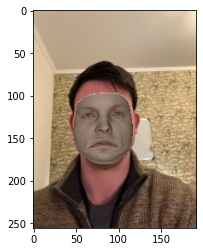

In [37]:
img_with_mask = np.array(img)
img_with_mask[depth != 0] = color[depth != 0]
plt.imshow(img_with_mask)
plt.show()

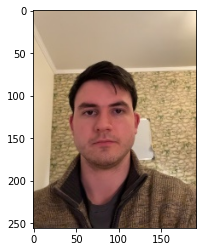

In [38]:
plt.imshow(img)

# 6. Diagnostics

In [39]:
def store_param_history(plot_manager, param_history):
    for i, params in enumerate(param_history):
        face_mesh = bfm.draw_sample(
            shape_coefficients=params.shape_coefficients,
            expression_coefficients=params.expression_coefficients,
            color_coefficients=[0 for _ in range(n_color_coefficients)],
        )
        translation = np.zeros((4, 4))
        translation[2, 3] = -150

        perspective_camera = get_perspective_camera(
            intrinsics, img_width, img_height,
        )
        scene = setup_standard_scene(perspective_camera)
        scene.add(
            pyrender.Mesh.from_points(
                pointcloud,
                colors=colors,
            ),
            pose=np.eye(4) + translation,
        )
        scene.add(
            pyrender.Mesh.from_trimesh(
                bfm.convert_to_trimesh(face_mesh),
            ),
            pose=params.camera_pose + translation,
        )

        r = pyrender.OffscreenRenderer(img_width * 2, img_height * 2)
        color, depth = r.render(scene)
        r.delete()

        fig = plt.figure(figsize=(8, 12))
        plt.imshow(color)
        plot_manager.save_current_plot(f"iteration_{i:05d}.jpg")
        plt.close()

## 6.1. Render Optimization Parameters per Step (Sparse) 

In [40]:
plot_manager = PlotManager.new_run("3d_sparse_reconstruction/fitting")
store_param_history(plot_manager, sparse_context.get_param_history())
plot_manager.generate_video('iteration_', '.jpg')

## 6.2. Render Optimization Parameters per Step (Dense) 

In [41]:
plot_manager = PlotManager.new_run("3d_dense_reconstruction/fitting")
store_param_history(plot_manager, dense_param_history)
plot_manager.generate_video('iteration_', '.jpg')

## 6.3. Reconstruction Error

In [42]:
plot_manager = PlotManager("reconstruction_error")

In [43]:
scene = setup_scene(show_pointcloud=False, show_mask=True)
r = pyrender.OffscreenRenderer(img_width, img_height)
color, depth = r.render(scene)
r.delete()

In [44]:
diff_img = np.abs(depth_img * 1000 - depth)
diff_img[depth == 0] = None

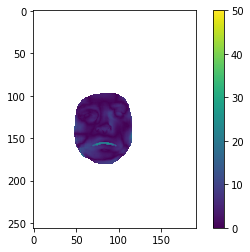

In [45]:
plt.imshow(diff_img)
plt.colorbar()
plt.clim(0, 50);
plt.show()